# Assignment

In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
from more_itertools import distribute

1. Consider a narrowbnad multipath communication channel with no line-of-sight

In [72]:
class JakesModel:
    def __init__(self, N, f_d):
        # Initial phases
        self.a_m = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        self.b_m = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        # Angle of arrivals
        # self.aoa = np.random.uniform(0, 2 * np.pi, size=(N, 1))
        self.aoa = np.arange(0, 2 * np.pi, 2 * np.pi / N).reshape(N, 1)  # No line of sight
        self.N = N
        self.f_d = f_d

    def get(self, t):
        # Keep in mind the numpy broadcasting rules!
        # https://numpy.org/doc/stable/user/basics.broadcasting.html
        re = np.cos(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.a_m)
        im = np.sin(2 * np.pi * self.f_d * np.cos(self.aoa) * t + self.b_m)
        return np.sum(re + 1j * im, axis=0) / np.sqrt(self.N)

2. Consider a slotted wireless channel: a base station sends a data to only one mobile device using a frame of length $T$ The frame length equals to $N$ independent chnnel uses. Consider an optimal code, that operates at Shannon's limit. Thus, the number of bits transmitted within a single frame is
$$
R = TB\log_2{\left(1 + \frac{S}{N}\right)}, \quad B = \frac{1}{\Delta t} \Rightarrow R = N\log_2{\left(1 + \frac{S}{N}\right)}
$$
2. Consider a base station communicating with multiple mobile devices using time-division multiplexing, when the base-station is able to send a frame to the only mobile device
3. Let the Doppler frequency being small w.r.t. transmittion time
$$
\frac{1}{T} \ll \frac{v}{\lambda}
$$

Note that the channel realizations between a base station and mobile devices are independent

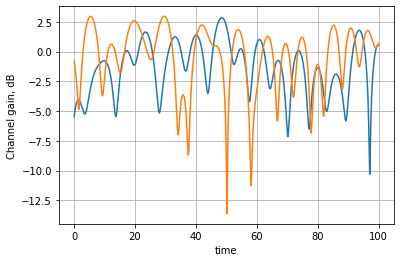

In [73]:
T = 1 # transmission time
f_d = 0.1 # Doppler frequency
n_paths = 100 # The number of paths in Jakes model
n_users = 2  # The number of users in the system
channels = [JakesModel(n_paths, f_d) for i in range(n_users)]

dt = 0.001
t = np.arange(0, 100, dt)


plt.figure()
for i in range(n_users):
    plt.plot(t, 10 * np.log10(np.abs(channels[i].get(t))))
plt.grid()
plt.ylabel('Channel gain, dB')
plt.xlabel('time')
plt.show()

As one can see, the channel conditions differ for different users. The task of the base station is to perform the scheduling: select a single user and transmit data to it. The performance measure may be:
* the sum data rate
* the worst 10% users data rate

The task for the current assignment is the following
1. Estimate different scheduling strategies: "round robbin" and "best channel conditions"
2. Evaluate the sum spectral efficiency given these two strategies (bit/s/Hz) for different number of users
3. Compare both strategies with the AWGN that has the same time-averaged SNR
4. Evaluate the "fairness" of each scheduling strategy

## Task 1 + Task 4
- Estimate different scheduling strategies: "round robbin" and "best channel conditions"
- Evaluate the "fairness" of each scheduling strategy 

#### Note:
- In this task results for 2 users
- SNR is the min value in slot of channel gain and it should be linear when calculating R
- "Fairness" calculated as Jain's fairness index = 1/(1+coefficient of variation^2) (https://en.wikipedia.org/wiki/Fairness_measure); coefficient of variation = standard deviation/average(https://en.wikipedia.org/wiki/Coefficient_of_variation).

In [74]:
def linear_from_dB(dB):
    return 10.0**(dB/10.0)

### Round Robin 
##### How it works: 
First slot to first user, second slot to the second user, etc

In [75]:
interval = 100
T_ = []
R = []

for i in np.arange(0,interval,T):
    T_.append(np.arange(i,i+T,dt))
    
slots_by_one_user = [list(c) for c in distribute(n_users, np.arange(interval))]
times_of_slots_by_one_user = []

for i in np.arange(n_users):
    times_of_slots_by_one_user.append(len(slots_by_one_user[i]))
    for j in np.arange(len(slots_by_one_user[i])):
        user = slots_by_one_user[i][j]
        SNR = min(10*np.log10(np.abs(channels[i].get(T_[user]))))
        R.append(np.log2(abs( 1 + linear_from_dB(SNR) )))

print("Average data rate R (average spectral efficiency) for", n_users, "users:", np.mean(R)) 
print("Sum data rate R (sum spectral efficiency) for", n_users, "users:", sum(R)) 
print("Number of slots that each user transfer:", slots_by_one_user) #This array demonstate which slots transfer each user, for example slots_by_one_user[0]-slots that first user transfer"
print("Times of transfer per one user:", times_of_slots_by_one_user)
print("Jain's fairness index:", 1/(1+(np.std(times_of_slots_by_one_user)/np.mean(times_of_slots_by_one_user))**2)) 

Average data rate R (average spectral efficiency) for 2 users: 0.8043779218035307
Sum data rate R (sum spectral efficiency) for 2 users: 80.43779218035307
Number of slots that each user transfer: [[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98], [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]]
Times of transfer per one user: [50, 50]
Jain's fairness index: 1.0


### Best channel condition

##### How it works: 
Find maximum gain in the slot and transfer data from this user

In [76]:
interval = 100
max_Gain_user = []
min_Gain_user = []
R = []
transfer_user = []

for i in np.arange(0,interval,T):
    t_ = np.arange(i,i+T,dt)
    for j in np.arange(n_users):
        Gain_user = 10 * np.log10(np.abs(channels[j].get(t_)))
        max_Gain_user.append(max(Gain_user))
        min_Gain_user.append(min(Gain_user))

new_max_Gain_user = [list(c) for c in distribute(n_users, max_Gain_user)] 
new_min_Gain_user = [list(c) for c in distribute(n_users, min_Gain_user)] 

for j in np.arange(interval):
    m = []
    for i in np.arange(n_users):
        m.append(new_max_Gain_user[i][j])
    transfer_user.append(m.index(max(m)))
    SNR = new_min_Gain_user[m.index(max(m))][j]
    R.append(np.log2(abs( 1+linear_from_dB(SNR) )))

print("Average data rate R (average spectral efficiency) for", n_users, "users:", np.mean(R)) 
print("Sum data rate R (sum spectral efficiency) for", n_users, "users:", sum(R)) 

print("User that transfer data in current slot:", transfer_user)#this is information about user transfer data in the folowing slot one by one

times_of_slots_by_one_user = [0] * n_users
for i in np.arange(interval):
    for j in np.arange(n_users):
        if transfer_user[i] == j: times_of_slots_by_one_user[j] +=1
print("Times of transfer per one user:", times_of_slots_by_one_user)
print("Jain's fairness index:", 1/(1+(np.std(times_of_slots_by_one_user)/np.mean(times_of_slots_by_one_user))**2)) 

Average data rate R (average spectral efficiency) for 2 users: 0.9998659611532291
Sum data rate R (sum spectral efficiency) for 2 users: 99.98659611532291
User that transfer data in current slot: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
Times of transfer per one user: [33, 67]
Jain's fairness index: 0.8963786303334529


## Task 2 + Task 4
- Evaluate the sum spectral efficiency given these two strategies (bit/s/Hz) for different number of users
- Evaluate the "fairness" of each scheduling strategy 

#### Note:
- Spectral efficiency in this situation means data rate (number of bits transmitted within a single frame)

In [77]:
interval = 100
N = 100
step = 10
R_range_rr = []; fairness_range_rr = []
R_range_bc = []; fairness_range_bc = []

for n in np.arange(2, N, step):
    n_users = n  
    channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
    interval = 100
    #======================================================================================
    # round robin calculations
    T_ = []
    R_rr = []
    
    for i in np.arange(0,interval,T):
        T_.append(np.arange(i,i+T,dt))

    slots_by_one_user_rr = [list(c) for c in distribute(n_users, np.arange(interval))]
    times_of_slots_by_one_user_rr = []

    for i in np.arange(n_users):
        times_of_slots_by_one_user_rr.append(len(slots_by_one_user_rr[i]))
        for j in np.arange(len(slots_by_one_user_rr[i])):
            user = slots_by_one_user_rr[i][j]
            SNR = min(10*np.log10(np.abs(channels[i].get(T_[user]))))
            R_rr.append(np.log2(abs( 1 + linear_from_dB(SNR) )))
    
    R_range_rr.append(sum(R_rr))
    fairness_range_rr.append(1/(1+(np.std(times_of_slots_by_one_user_rr)/np.mean(times_of_slots_by_one_user_rr))**2))
    #======================================================================================
    #best channel conditions calculations
    max_Gain_user = []
    min_Gain_user = []
    R_bc = []
    transfer_user = []
    
    for i in np.arange(0,interval,T):
        t_ = np.arange(i,i+T,dt)
        for j in np.arange(n_users):
            Gain_user = 10 * np.log10(np.abs(channels[j].get(t_)))
            max_Gain_user.append(max(Gain_user))
            min_Gain_user.append(min(Gain_user))

    new_max_Gain_user = [list(c) for c in distribute(n_users, max_Gain_user)] 
    new_min_Gain_user = [list(c) for c in distribute(n_users, min_Gain_user)] 

    for j in np.arange(interval):
        m = []
        for i in np.arange(n_users):
            m.append(new_max_Gain_user[i][j])
        transfer_user.append(m.index(max(m)))
        SNR = new_min_Gain_user[m.index(max(m))][j]
        R_bc.append(np.log2(abs( 1+linear_from_dB(SNR) )))
    
    R_range_bc.append(sum(R_bc))

    times_of_slots_by_one_user_bc = [0] * n_users
    for i in np.arange(interval):
        for j in np.arange(n_users):
            if transfer_user[i] == j: times_of_slots_by_one_user_bc[j] +=1
    fairness_range_bc.append(1/(1+(np.std(times_of_slots_by_one_user_bc)/np.mean(times_of_slots_by_one_user_bc))**2))
    #======================================================================================

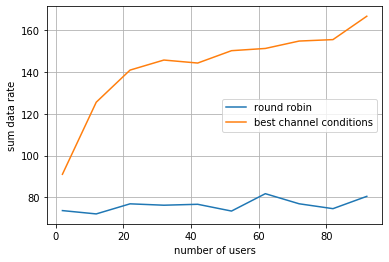

In [78]:
plt.plot(np.arange(2, N, step),R_range_rr)
plt.plot(np.arange(2, N, step),R_range_bc)
plt.ylabel('sum data rate'); plt.xlabel('number of users')
plt.legend(('round robin', 'best channel conditions'), loc='center right')
plt.grid()

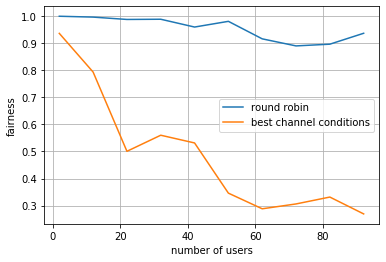

In [79]:
plt.plot(np.arange(2, N, step),fairness_range_rr)
plt.plot(np.arange(2, N, step),fairness_range_bc)
plt.ylabel('fairness'); plt.xlabel('number of users')
plt.legend(('round robin', 'best channel conditions'), loc='center right')
plt.grid()

## Task 3 + Task 4
- Compare both strategies with the AWGN that has the same time-averaged SNR
- Evaluate the "fairness" of each scheduling strategy 

#### Steps:
1. Determine the gain h
2. Take sigma as 1
3. Based on point 1, 2 find a new channel gain. It will count as |h|^2/sigma^2, because time-averaged received power equal 1

Text(0, 0.5, 'Channel gain, dB')

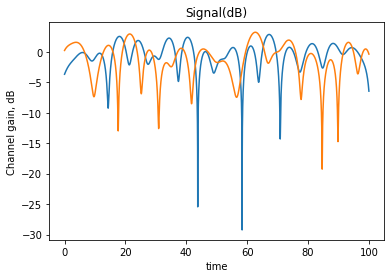

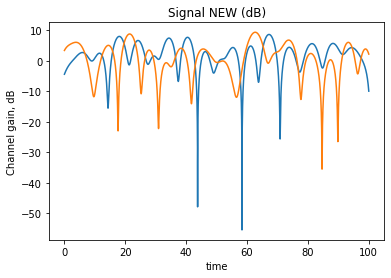

In [80]:
n_users = 2  # The number of users in the system
channels = [JakesModel(n_paths, f_d) for i in range(n_users)]
x1 = channels[0].get(t); x1_dB = 10*np.log10(np.abs(x1))
x2 = channels[1].get(t); x2_dB = 10*np.log10(np.abs(x2))
sigma = 1
h1 = np.sqrt(2)*x1;h2 = np.sqrt(2)*x2
target_gain1 = np.abs(h1)**2/sigma**2;target_gain2 = np.abs(h2)**2/sigma**2
target_gain1_dB = 10 * np.log10(target_gain1);target_gain2_dB = 10 * np.log10(target_gain2)
plt.figure(1); plt.plot(t, x1_dB); plt.plot(t, x2_dB); plt.title('Signal(dB)'); plt.xlabel('time'); plt.ylabel('Channel gain, dB')
plt.figure(2); plt.plot(t, target_gain1_dB); plt.plot(t, target_gain2_dB); plt.title('Signal NEW (dB)'); plt.xlabel('time'); plt.ylabel('Channel gain, dB')

After these three steps, our signal is stretched along the y-axis (as seen in the pictures above)
4. Apply algorithms, using them determine the SNR and find the sum data rate and fairness
5. Build two graphs: dependence of the sum data rate and fairness on the users number

In [81]:
interval = 100
N = 100
step = 10
R_range_rr = []; fairness_range_rr = []
R_range_bc = []; fairness_range_bc = []

for n in np.arange(2, N, step):
    n_users = n  
    channels = [JakesModel(n_paths, f_d) for i in range(n_users)]

    target_gain_dB = [[0] * len(channels[0].get(t))] * n_users
    for i in np.arange(n_users):
        x = channels[i].get(t)
        sigma = 1
        h = np.sqrt(2)*x
        target_gain = np.abs(h)**2/sigma**2
        target_gain_dB[i] = 10 * np.log10(target_gain)
    
    target_gain_dB_splited =  [[[0] * 1000] * interval] * n_users
    for j in np.arange(n_users):
        for i in np.arange(0,interval,T):
            target_gain_dB_splited[j][i] = target_gain_dB[j][i*1000:(i+1)*1000]
    #======================================================================================
    # round robin calculations  
    slots_by_one_user_rr = [list(c) for c in distribute(n_users, np.arange(interval))]
    times_of_slots_by_one_user_rr = []
    R_rr = []
    
    for i in np.arange(n_users):
        times_of_slots_by_one_user_rr.append(len(slots_by_one_user_rr[i]))
        for j in np.arange(len(slots_by_one_user_rr[i])):
            user = slots_by_one_user_rr[i][j]
            SNR = min(target_gain_dB_splited[i][user])        
            R_rr.append(np.log2(abs( 1 + linear_from_dB(SNR) )))
    
    R_range_rr.append(sum(R_rr))
    fairness_range_rr.append(1/(1+(np.std(times_of_slots_by_one_user_rr)/np.mean(times_of_slots_by_one_user_rr))**2))
    #======================================================================================
    #best channel conditions calculations
    max_Gain_user = []
    min_Gain_user = []
    transfer_user = []
    R_bc = []

    for j in np.arange(n_users):
        for i in np.arange(0,interval,T):
        
            Gain_user = target_gain_dB_splited[j][i]
            max_Gain_user.append(max(Gain_user))
            min_Gain_user.append(min(Gain_user))
    
    new_max_Gain_user = [list(c) for c in distribute(n_users, max_Gain_user)] 
    new_min_Gain_user = [list(c) for c in distribute(n_users, min_Gain_user)] 

    for j in np.arange(interval):
        m = []
        for i in np.arange(n_users):
            m.append(new_max_Gain_user[i][j])
        transfer_user.append(m.index(max(m)))
        SNR = new_min_Gain_user[m.index(max(m))][j]
        R_bc.append(np.log2(abs( 1+linear_from_dB(SNR) )))

    R_range_bc.append(sum(R_bc))

    times_of_slots_by_one_user_bc = [0] * n_users
    for i in np.arange(interval):
        for j in np.arange(n_users):
            if transfer_user[i] == j: times_of_slots_by_one_user_bc[j] +=1
    fairness_range_bc.append(1/(1+(np.std(times_of_slots_by_one_user_bc)/np.mean(times_of_slots_by_one_user_bc))**2))

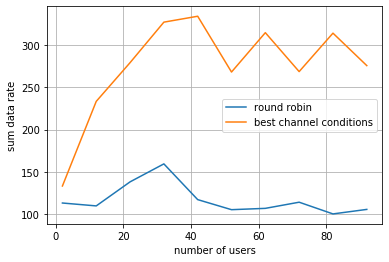

In [82]:
plt.plot(np.arange(2, N, step),R_range_rr)
plt.plot(np.arange(2, N, step),R_range_bc)
plt.ylabel('sum data rate'); plt.xlabel('number of users')
plt.legend(('round robin', 'best channel conditions'), loc='center right')
plt.grid()

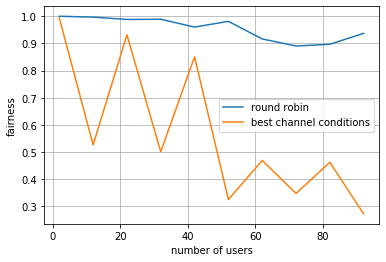

In [83]:
plt.plot(np.arange(2, N, step),fairness_range_rr)
plt.plot(np.arange(2, N, step),fairness_range_bc)
plt.ylabel('fairness'); plt.xlabel('number of users')
plt.legend(('round robin', 'best channel conditions'), loc='center right')
plt.grid()

### Conclusion: 
Round robbin shows better fairness (because it always transfers data from all users), Best channel conditions shows better sum data rate (because it finds max gain)